### In this part, we will finetune the ViT model to Stanford Dogs Dataset

In [2]:
import PIL
import numpy as np
from tqdm import tqdm
import torch
import torch.optim as optim
from torchvision import transforms
from models.models_to_finetune import deit_small_patch16_224
from datasets import CUBDataset, DOGDataset
import math

In [3]:

import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Setup dataset

In [20]:
# Set train and test set
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
data_root = "./dog/dog/"
train_dataset = DOGDataset(image_root_path=f"{data_root}", transform=data_transform, split="train")
test_dataset = DOGDataset(image_root_path=f"{data_root}", transform=data_transform, split="test")
print('Number of train samples:', len(train_dataset))
print('Number of test samples:', len(test_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, drop_last=False)

Number of train samples: 12000
Number of test samples: 8580


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'> torch.Size([224, 224, 3])


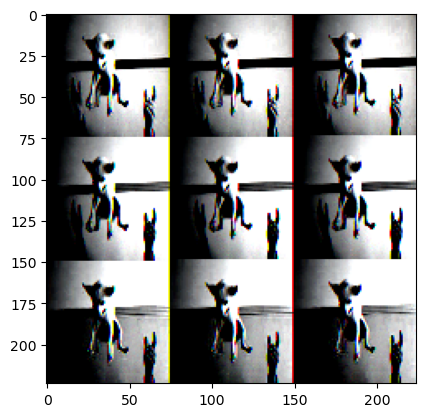

In [21]:
import matplotlib.pyplot as plt
tensor_image = train_dataset[0][0]
tensor_image = tensor_image.view(tensor_image.shape[1], tensor_image.shape[2], tensor_image.shape[0])
print(type(tensor_image), tensor_image.shape)

plt.imshow(tensor_image)
plt.show()

In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])
data_root = "./CUB_200_2011/"
train_dataset = CUBDataset(image_root_path=f"{data_root}", transform=data_transform, split="train")
test_dataset = CUBDataset(image_root_path=f"{data_root}", transform=data_transform, split="test")
print('Number of train samples:', len(train_dataset))
print('Number of test samples:', len(test_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, drop_last=False)

Number of train samples: 5994
Number of test samples: 5794


In [18]:
# import matplotlib.pyplot as plt
# print(train_dataset)
# # plt.imshow(  train_dataset[0][0].permute(1, 2, 0)  )

# tensor_image = train_dataset[0][0]
# tensor_image = tensor_image.view(tensor_image.shape[1], tensor_image.shape[2], tensor_image.shape[0])
# print(type(tensor_image), tensor_image.shape)

# plt.imshow(tensor_image)
# plt.show()


In [23]:
num_epochs = 30
learning_rate = 0.001
batch_size = 100

# model_name = 'ResNet'
model_name = 'Simple_CNN'    

In [59]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.fc1 = nn.Linear(128 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 200)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [56]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        print("......0.......")
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 200)

    def forward(self, x):
        print("......1.......")
        x = self.conv1(x)
        print("......2.......")
        # x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)
        print(x.shape)
        
        x = self.conv2(x)
        # x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # x = self.pool(F.relu(self.conv2(x)))
        # here
        # x = self.bn2(x)  #  add RELU
        print("......3.......")
        print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch   
        print('flattened: ', x.shape)     
        # x = F.relu(self.fc1(x))   # here also between FC and relu

        x = self.fc1(x)
        x = F.relu(x)

        print("......4.......")
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [60]:
if model_name == 'Simple_CNN':
    model = Simple_CNN().to(device)
    print(model)
else:
    model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)    #  by 2 blocks

Simple_CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=200, bias=True)
)


In [15]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [61]:
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        print(images.shape)
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimizes
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    if (epoch+1) % 20 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

torch.Size([32, 3, 224, 224])


RuntimeError: mat1 dim 1 must match mat2 dim 0

In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), model_name + '.ckpt')

In [ ]:
if model_name == 'Simple_CNN':
    model = Simple_CNN().to(device)
else:
    model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

PATH = './' + model_name + '.ckpt'
model.load_state_dict(torch.load(PATH))


## Prepare ViT for transfer learning

In [21]:
# like we discussed in part1, we will use only the last class token (produced by the last block) for transfer learning
model = deit_small_patch16_224(pretrained=True, use_top_n_heads=4,use_patch_outputs=False).cuda()
# freeze backbone and add linear classifier on top that is for 120 classes
for param in model.parameters():
        param.requires_grad = False
model.head = torch.nn.Linear(in_features=model.head.in_features, out_features=120) # dogs dataset has 120 classes

_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])


In [22]:
model.head.apply(model._init_weights)
for param in model.head.parameters():
    param.requires_grad = True

model = model.to(device)

In [23]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.5, 0.999))

## Training

In [24]:
epochs = 2
print('Training....')
for epoch in range(epochs):
    with tqdm(train_loader) as p_bar:
        for samples, targets in p_bar:
            samples = samples.to(device)
            targets = targets.to(device)
            
            outputs = model(samples, fine_tune=True)
            loss = criterion(outputs, targets)

            loss_value = loss.item()
            if not math.isfinite(loss_value):
                print("Loss is {}, stopping training".format(loss_value))
                sys.exit(1)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

  0%|          | 0/375 [00:00<?, ?it/s]

Training....


100%|██████████| 375/375 [01:24<00:00,  4.44it/s]


## Testing

In [ ]:
print('Testing....')
acc=0
with tqdm(test_loader) as p_bar:
    for samples, targets in p_bar:
        samples = samples.to(device)
        targets = targets.to(device)
        
        outputs = model(samples, fine_tune=True)
        acc+=torch.sum(outputs.argmax(dim=-1) == targets).item()

print('Accuracy:{0:.3%}'.format(acc/len(test_dataset)))



## To Do
* Change number of training epochs
* Change number of class tokens e.g, use_top_n_heads=4, etc